Auteurs du rapport  : Kastriot Kozhani, Blerdon Débieux, Kevin Zulliger 
# RealEstateScout - Prédictions des prix de ventes de maisons

## Introduction - phase zéro 
Avez-vous déjà mis en vente ou en location un bien immobilier sans savoir quel prix lui attribuer ? 

Notre équipe de data scientists est chargée de développer une marketplace mettant en relation les acheteurs et les vendeurs d'immobilier. En offrant des prédictions de prix précises, nous inciterons les vendeurs à fournir un maximum de détails sur leurs biens. Les vendeurs renseignant le plus de paramètres seront récompensés par une réduction sur le coût de leur annonce. Cela nous garantira une meilleure qualité des données, améliorant ainsi la précision de notre système de prédiction. 

Le type de tâche que nous avons souhaité réaliser est une régression pour prédire le prix de vente d'une propriété, le tout principalement en faveur des agences immobilières.
La raison est simple: la prédiction des prix de l'immobilier représente un enjeu crucial pour les agences immobilières et les vendeurs de proprietés. Ces dernières pourront utiliser nos prédictions pour fixer des prix de vente compétitifs qui reflètent la valeur réelle du marché immobilier. De ce fait, les agences immobilières renforceront leur position sur le marché tout en améliorant la satisfaction de ses clients.
Pour arriver à notre but, nous avons entrepris de développer un modèle de Machine Learning robuste, capable de prédire l'estimation du prix de vente d'une maison sur la base de différents critères et données.

Ce projet s'inscrit dans un contexte où la détermination d'un prix de vente juste et compétitif est essentiel pour optimiser la visibilité des annonces, accélérer les transactions et maximiser les revenus des vendeurs. Pour atteindre ces objectifs, nous avons adopté une méthodologie basée sur le processus CRISP-ML (Cross-Industry Standard Process for Data Mining), qui nous guide de la compréhension initiale des données jusqu'au déploiement final du modèle.

## Phase d'idéation - Exploration du jeu de données 

### Critères de succès 
- Performance du modèle 
- marketplace adapté au besoin
- La métrique utilisée pour définir si notre modèle sera performant sera le RMSLE. Cette dernière est mathématiquement définie de la manière suivante: 

$$
\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(p_i + 1) - \log(a_i + 1))^2}
$$

  -- Un score bas indiquera que notre modèle sera performant. L'objectif sera d'obtenir un score RMSLE en dessous de 0.12, ce qui serait un objectif challenging pour ce projet. Dans la pratique, cela se traduira par une prédictions des prix de maisons proches de la réalité. 

- Un autre critère de succès sera que notre marketplace réponde aux besoins des vendeurs ainsi que des acheteurs. Les deux parties devront se familiariser assez rapidement avec notre plateforme.
Nous évaluerons ce critère à travers des tests d'utilisabilité et des retours d'expérience des utilisateurs.

## Importation des données et constitution de la pipeline

Cette étape importe les bibliothèques nécessaires pour la manipulation des données, la visualisation, et les techniques de modélisation. Elle est cruciale pour configurer notre environnement de travail et assurer que nous avons tous les outils nécessaires pour le traitement des données ainsi que pour la modélisation.

In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import TargetEncoder  # Import du TargetEncoder de sklearn
import xgboost as xgb
import optuna
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

Nous commençons par charger les données d'entraînement et de test à partir des fichiers CSV à disposition sur Kaggle. L'affichage des premières lignes nous a permis de consulter la structure des données initiale ainsi que de vérifier l'importation.

In [51]:
train_data = pd.read_csv('Data/train.csv',index_col="Id" )
test_data = pd.read_csv('Data/test.csv',index_col="Id" )

Nous avons  trouvé que les ventes partielles constituaient un danger dans la prédiction car ces ventes définies comme telles n'ont en fait jamais été conclues. Nous les avons donc supprimer de notre dataset afin d'éviter des biais. 

In [52]:
train_data = train_data[train_data['SaleCondition'] != 'Partial']

Nous avons ensuite définit les colonnes selon leur type (numériques, catégorielles, ordinales, dichotomiques). Cette étape est essentielle afin d'appliquer des techniques de prétraitement qui sont spécifiques à chaque type de données. Voici les différents types de données à disposition:

- Features numériques : Variables quantitatives mesurées sur une échelle numérique.
- Features catégorielles : Variables qualitatives qui peuvent prendre plusieurs catégories.
- Features ordinales : Variables qualitatives ordonnées qui ont une relation d'ordre.
- Features dichotomiques : Variables qui prennent deux valeurs possibles (oui/non).

In [53]:
numeric_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
                    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                    'MiscVal', 'MoSold', 'YrSold']

categorical_features = ['MSSubClass', 'MSZoning', 'Alley', 'Neighborhood', 'Condition1', 'Condition2', 
                        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 
                        'SaleType', 'SaleCondition']

ordinal_features = ['LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'OverallQual', 
                    'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 
                    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

dichotomous_features = ['CentralAir', 'Street']

# Compréhension des données

Comme expliqué dans l'exploration du jeu de données, le dataset utilisé contient des informations détaillées sur différentes propriétés, incluant des caractéristiques comme la superficie, l'année de construction, la qualité des matériaux, etc. Nous avons commencé par une analyse exploratoire des données pour identifier les caractéristiques les plus influentes et comprendre leur distribution.

## Analyse exploratoire
- **MSSubClass**: Classe du bâtiment
- **MSZoning**: Classification de la zone
- **LotArea**: Taille du terrain
- **OverallQual**: Qualité générale des matériaux et de la finition
- **YearBuilt**: Année de construction

Nous avons observé que certaines variables comme `OverallQual` et `GrLivArea` avaient une forte corrélation avec le prix de vente, , ce qui nous permet de mieux comprendre les facteurs influençant les prix des maisons


# Préparation des données

Pour garantir la qualité des prédictions, il est nécessaire d'avoir un jeu de données bien préparé. Nous avons ainsi effectué les étapes suivantes :

1. **Nettoyage des données** : Gestion des valeurs manquantes et des anomalies.
2. **Transformation des variables** : Encodage des variables catégorielles, normalisation des variables numériques.
3. **Feature Engineering** : Création de nouvelles variables basées sur les caractéristiques existantes, comme l'âge de la maison depuis sa construction.

## Matrice de corrélation

Afin de savoir quelles variables sont le plus décisives dans la définition du prix d'une maison, nous avons procédé à l'affichage d'une matrice de corrélation afin de constater quelles sont les variables de notre data set qui sont le plus corrélées.

Pour cela, nous avons suivis quelques étapes :

1. **Calcul de la matrice de corrélation :** Nous avons commençé par calculer la matrice de corrélation pour les variables numériques. Cette matrice nous a montré les coefficients de corrélation entre chaque paire de variables, indiquant à quel point elles sont linéairement liées.

2. **Filtrage des corrélations significatives :** Nous avons ensuite filtrés les corrélations pour ne conserver que celles qui sont supérieures à 0.8 ou inférieures à -0.8. Cela nous a permis de nous concentrer sur les relations les plus fortes, qui ont le plus d'impact sur le prix de vente des maisons.

3. **Affichage de la matrice de corrélation filtrée :** Enfin, nous avons affiché la matrice de corrélation filtrée à l'aide d'une heatmap. Les valeurs NaN (non significatives) ont été masquées pour une plus grande lisibilité.

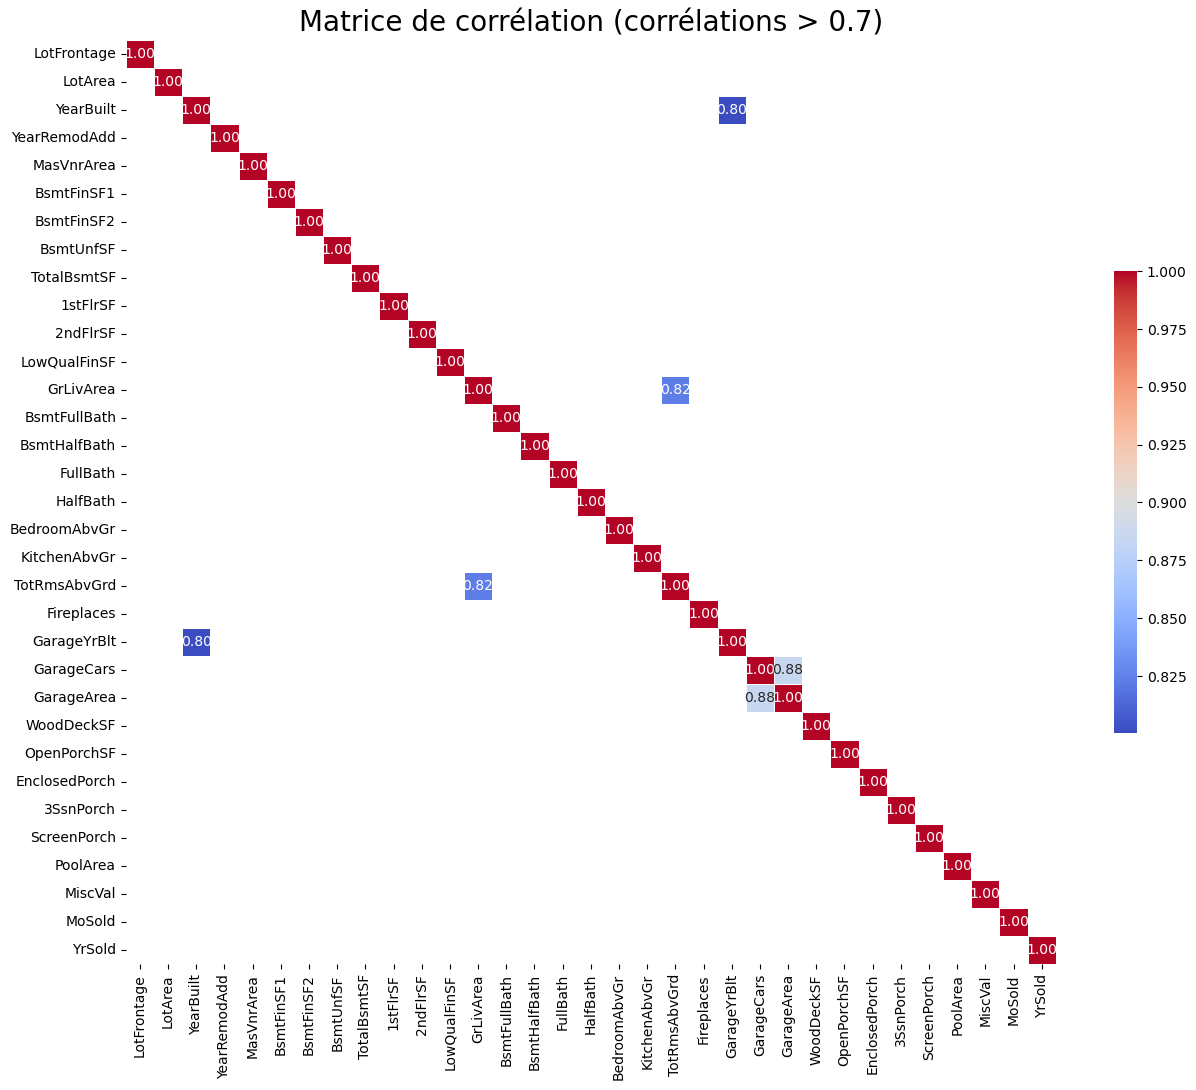

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculer la matrice de corrélation
numeric_data = train_data[numeric_features]
correlation_matrix = numeric_data.corr()

# Filtrer les corrélations supérieures à 0.8 ou inférieures à -0.8
filtered_corr_matrix = correlation_matrix[(correlation_matrix.abs() >= 0.8)]

# Masquer les valeurs NaN pour l'affichage
mask = np.isnan(filtered_corr_matrix)

# Afficher la matrice de corrélation filtrée
plt.figure(figsize=(15, 12))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, mask=mask, cbar_kws={"shrink": .5})
plt.title('Matrice de corrélation (corrélations > 0.7)', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


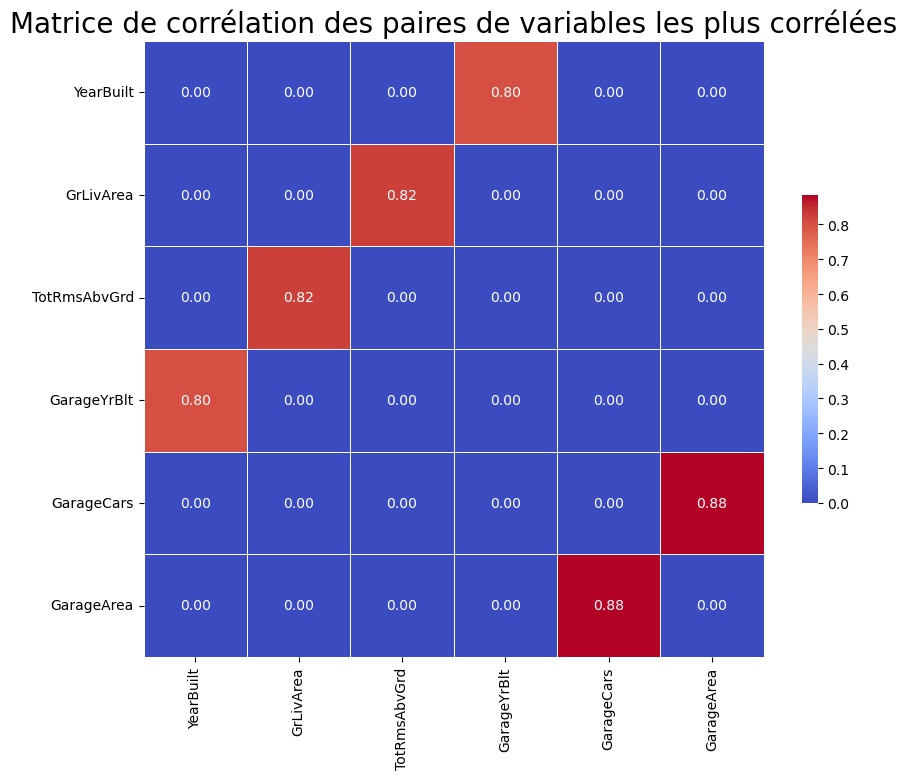

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculer la matrice de corrélation
correlation_matrix = numeric_data.corr()

# Sélectionner les paires de variables les plus corrélées
high_corr_pairs = [
    ('GarageYrBlt', 'YearBuilt'),
    ('TotRmsAbvGrd', 'GrLivArea'),
    ('GarageArea', 'GarageCars')
]

# Créer une nouvelle DataFrame pour contenir uniquement les paires sélectionnées
high_corr_matrix = pd.DataFrame(0, index=numeric_data.columns, columns=numeric_data.columns)

for pair in high_corr_pairs:
    high_corr_matrix.loc[pair[0], pair[1]] = correlation_matrix.loc[pair[0], pair[1]]
    high_corr_matrix.loc[pair[1], pair[0]] = correlation_matrix.loc[pair[1], pair[0]]

# Filtrer les lignes et colonnes qui ne contiennent que des zéros
high_corr_matrix = high_corr_matrix.loc[(high_corr_matrix != 0).any(axis=1), (high_corr_matrix != 0).any(axis=0)]

# Afficher la matrice de corrélation filtrée
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matrice de corrélation des paires de variables les plus corrélées', fontsize=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


#### **Conclusion de la matrice** 

***YearBuilt - GarageYrBlt (0.80)***

YearBuilt : Année de construction de la maison.
GarageYrBlt : Année de construction du garage.

Interprétation : Il est logique que l'année de construction de la maison et du garage soient fortement corrélées, car les garages sont souvent construits en même temps que les maisons.

***TotRmsAbvGrd - GrLivArea (0.82)***

TotRmsAbvGrd : Nombre total de pièces au-dessus du sol (ne comprend pas les salles de bains).

GrLivArea : Surface habitable au-dessus du sol en pieds carrés.

Interprétation : Une plus grande surface habitable est généralement associée à un plus grand nombre de pièces.

***GarageArea - GarageCars (0.88)***

GarageArea : Surface du garage en pieds carrés.
GarageCars : Capacité du garage en nombre de voitures.

Interprétation : La surface du garage est directement liée à la capacité du garage en termes de nombre de voitures. Plus la surface est grande, plus le garage peut accueillir de voitures.

In [56]:
# Data preprocessing with pipelines
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

dichotomous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary'))
])

# Combine features in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_features),
        ('num', numeric_pipeline, numeric_features),
        ('ord', ordinal_pipeline, ordinal_features),
        ('dich', dichotomous_pipeline, dichotomous_features)
    ])


# Séparation de la variable cible et des caractéristiques.
# Transformation du prix de vente en utilisant la fonction log1p pour normaliser les valeurs et réduire l'impact des valeurs extrêmes.
y_train = np.log1p(train_data['SalePrice'])
X_train = train_data.drop(['SalePrice'], axis=1)

# Application du ColumnTransformer aux données d'entraînement et de test.
# Cette étape applique toutes les transformations définies précédemment aux données.
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_test_transformed = preprocessor.transform(test_data)

preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MSSubClass', 'MSZoning', 'Alley',
                                  'Neighborhood', 'Condition1', 'Condition2',
                                  'BldgType', 'HouseStyle', 'RoofStyle',
                                  'RoofMatl', 'Exterior1st', 'Exterior2nd',
                                  'MasVnrType', 'Foundation', 'Heating',
                                  'Elec...
                                  'OverallCond', 'ExterQual', 'ExterCond',
                                  'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                  'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                                  'KitchenQual', 'Functional', 'FireplaceQu',
                                  'GarageFinish', 'GarageQual', 'GarageCond',
                                  'PavedDrive', 'PoolQC', 'Fence']),
                                ('dich',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['CentralAir', 'Street'])])

In [57]:

# Converting back to Pandas DataFrame
X_train_df = pd.DataFrame(X_train_transformed, index=train_data.index)
X_test_df = pd.DataFrame(X_test_transformed, index=test_data.index)

# Afficher les 5 premières lignes du jeu de données prétraité pour vérifier
print(X_train_df.head())
print(X_test_df.head())

    0    1    2    3    4    5    6    7    8    9    ...  212  213  214  215  \
Id                                                    ...                       
1   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  6.0  4.0  1.0  4.0   
2   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6.0  4.0  1.0  4.0   
3   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  6.0  4.0  1.0  4.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  6.0  2.0  2.0  4.0   
5   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  6.0  4.0  1.0  4.0   

    216  217  218  219  220  221  
Id                                
1   4.0  2.0  0.0  2.0  1.0  1.0  
2   4.0  2.0  0.0  2.0  1.0  1.0  
3   4.0  2.0  0.0  2.0  1.0  1.0  
4   4.0  2.0  0.0  2.0  1.0  1.0  
5   4.0  2.0  0.0  2.0  1.0  1.0  

[5 rows x 222 columns]
      0    1    2    3    4    5    6    7    8    9    ...  212  213  214  \
Id                                                      ...                  
1461  1

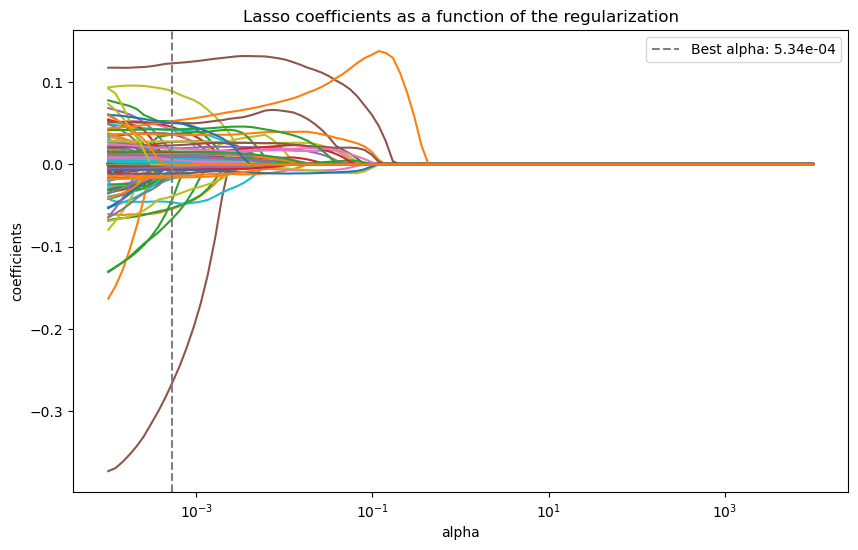

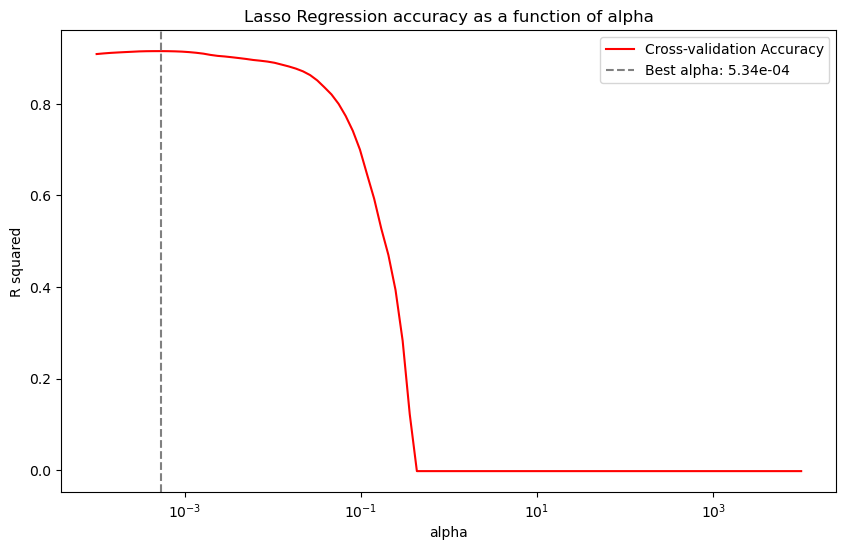

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.exceptions import ConvergenceWarning
import warnings

# Filtrer les avertissements de convergence
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Définir les alphas pour Lasso
lasso_alphas = 10**np.linspace(-4, 4, 100)

# Entraînement de la régression Lasso et collecte des coefficients et scores de validation croisée
lasso_regression = Lasso(max_iter=20000)
lasso_coefs = []
lasso_cv = []

for alpha in lasso_alphas:
    lasso_regression.set_params(alpha=alpha)
    lasso_regression.fit(X_train_df, y_train)
    lasso_coefs.append(lasso_regression.coef_)
    scores = cross_val_score(lasso_regression, X_train_df, y_train, cv=5, scoring='r2')
    lasso_cv.append(scores.mean())

# Trouver l'alpha avec la meilleure précision (score moyen le plus élevé)
best_alpha = lasso_alphas[np.argmax(lasso_cv)]

# Tracer les coefficients en fonction des alphas
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(lasso_alphas, lasso_coefs)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.axvline(x=best_alpha, color='grey', linestyle='--', label=f'Best alpha: {best_alpha:.2e}')
plt.legend()
plt.show()

# Tracer la précision en fonction des alphas
plt.figure(figsize=(10, 6))
plt.plot(lasso_alphas, lasso_cv, color='red', label='Cross-validation Accuracy')
plt.axvline(x=best_alpha, color='grey', linestyle='--', label=f'Best alpha: {best_alpha:.2e}')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('R squared')
plt.title('Lasso Regression accuracy as a function of alpha')
plt.legend()
plt.show()



**Conclusion du modèle lasso**

Plus on va vers la gauche du graphe, plus nous avons des coefficients avec des valeurs aberrantes.

Grâce à ce graphique, nous avons pu contrôler l'overfitting et identifier la valeur optimale de 𝛼 pour obtenir un modèle Lasso bien régularisé.

Cela nous a permi d'ajuster les paramètres de régularisation dans XGBoost, ce qui nous a aidé à contrôler l'overfitting.

Nous constatons sur le graphique qu'une valeur alpha à 10^-3 serait adapté. Au-delà, nous constatons que la courbe s'applatit. Cela signifie que le surapprentissage est réellement présent. 

### Analyse des premières lignes des données transformées


In [59]:

print(X_train_df.describe())
print(X_train_df.head())

               0            1            2            3            4    \
count  1335.000000  1335.000000  1335.000000  1335.000000  1335.000000   
mean      0.352809     0.051685     0.002996     0.008989     0.107865   
std       0.478023     0.221474     0.054676     0.094417     0.310326   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               5            6            7            8            9    ...  \
count  1335.000000  1335.000000  1335.000000  1335.000000  1335.000000  ...   
mean      0.192509     0.044944     0.011985     0.043446     0.014981  ...   
std       0.394419     0.207258     0.108859     0.203935     0.121523  ...   
min       0.00000

 - Les premières lignes montrent des exemples concrets des valeurs transformées.
 - Cela permet de vérifier visuellement que l'imputation, l'encodage et la normalisation ont été correctement appliqués.
 - Ces valeurs fournissent un aperçu rapide de la manière dont les données d'entraînement sont structurées après prétraitement.



In [60]:
best_alpha = 10**-3

print(f"La meilleure valeur d'alpha est : {best_alpha}")

La meilleure valeur d'alpha est : 0.001


### Lasso Regression

In [61]:
# Entraîner le modèle Lasso avec la meilleure valeur d'alpha
final_lasso = Lasso(alpha=10**-3, max_iter=20000)
final_lasso.fit(X_train_df, y_train)

# Prédire sur les données de test avec le modèle Lasso
lasso_predictions = final_lasso.predict(X_test_df)
lasso_predictions = np.expm1(lasso_predictions)  # Inverser la transformation log1p


### Analyse du graphique Prédictions vs Valeurs Réelles :


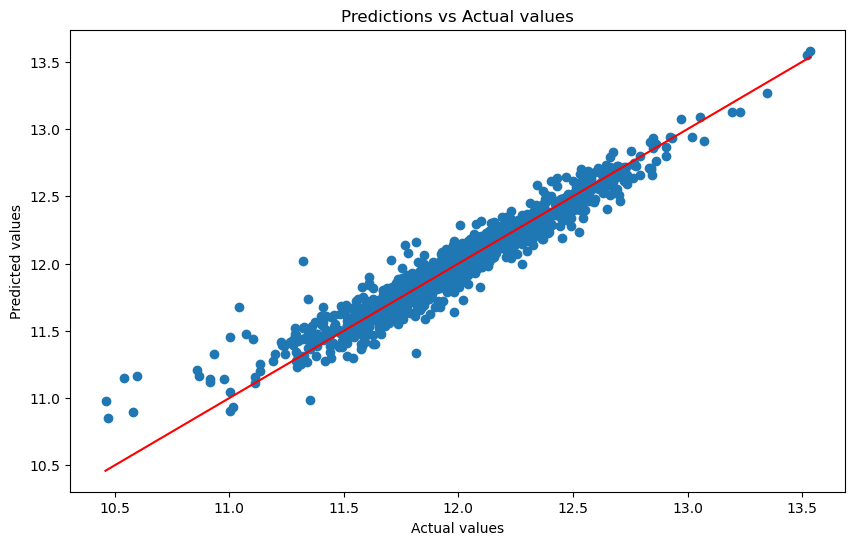

In [62]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, final_lasso.predict(X_train_df))
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predictions vs Actual values')
plt.show()

Nous constatons que les valeurs  prédites disposant d'un prix de vente minime ont été surévalulés. Cela est dû au fait que notre dataset dispose peu de données sur les maisons en dessous de la moyenne au niveau du prix de vente. 

### Analyse de la sélection de la meilleure valeur d'alpha
 - La meilleure valeur d'alpha est sélectionnée en utilisant les scores de validation croisée.
 - Cela garantit que nous choisissons une valeur d'alpha qui optimise la performance du modèle sur des données de validation, et non uniquement sur les données d'entraînement.
 - En affichant la meilleure valeur d'alpha, nous pouvons l'utiliser pour entraîner notre modèle final de régression Lasso, assurant ainsi la meilleure performance possible.

### XGradient Boosting
Pour optimiser les hyperparamètres du modèle ExtremmeGradientBoosting, nous avons utilisé Optuna avec la fonction RMSLE (Root Mean Squared Log Error) comme métrique d'évaluation (qui est particulièrement appropriée pour des valeurs cibles avec une large gamme ou des valeurs extrêmes). Les données prétraitées sont préparées pour Optuna, et une fonction d'objectif spécifie les hyperparamètres à optimiser. 

In [63]:
import optuna
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
import xgboost as xgb

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

X_preprocessed = X_train_df
y = y_train

def objective_xgb(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': 1e-2,  # Utiliser la valeur ajustée d'alpha
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'early_stopping_rounds': 50  #éviter le warning
    }

    model = xgb.XGBRegressor(**xgb_params, random_state=42, objective='reg:squarederror')
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmsle_scores = []
    
    for train_index, valid_index in kf.split(X_preprocessed):
        X_train, X_valid = X_preprocessed.iloc[train_index], X_preprocessed.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        model.fit(X_train, np.log1p(y_train), eval_set=[(X_valid, np.log1p(y_valid))], verbose=False)
        preds = model.predict(X_valid)
        score = rmsle(np.log1p(y_valid), preds)
        rmsle_scores.append(score)
    
    return np.mean(rmsle_scores)

sampler = optuna.samplers.TPESampler()
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=200)  

print("Best hyperparameters for XGB =", study_xgb.best_trial.params)

final_model_xgb = xgb.XGBRegressor(**study_xgb.best_trial.params, random_state=42, objective='reg:squarederror')
final_model_xgb.fit(X_train_df, y_train, eval_set=[(X_train_df, np.log1p(y_train))], verbose=False)

[I 2024-06-18 22:14:19,636] A new study created in memory with name: no-name-3a041e4a-8b2f-4f67-a35d-9317042838a6
[I 2024-06-18 22:14:45,426] Trial 0 finished with value: 0.002733715605589303 and parameters: {'n_estimators': 1751, 'max_depth': 8, 'learning_rate': 0.014556429820682278, 'subsample': 0.8547881494957734, 'colsample_bytree': 0.968874318867242, 'min_child_weight': 10, 'reg_lambda': 2.1134778554798635e-08, 'gamma': 2.1864104930099238e-08}. Best is trial 0 with value: 0.002733715605589303.
[I 2024-06-18 22:14:48,097] Trial 1 finished with value: 0.008205167979236982 and parameters: {'n_estimators': 1831, 'max_depth': 16, 'learning_rate': 0.15132623200943388, 'subsample': 0.8694918405216159, 'colsample_bytree': 0.3305242049726893, 'min_child_weight': 4, 'reg_lambda': 0.00015848335306225487, 'gamma': 0.4129655200536892}. Best is trial 0 with value: 0.002733715605589303.
[I 2024-06-18 22:14:58,362] Trial 2 finished with value: 0.0025974843242431425 and parameters: {'n_estimators'

KeyboardInterrupt: 

Pour évaluer la performance du modèle XGBoost sur des données non vues, nous avons utilisé le modèle final entraîné pour prédire les valeurs cibles des données de test. Les prédictions sur les données d'entraînement ont également été effectuées pour analyser la performance du modèle sur cet ensemble. Les prédictions et les valeurs réelles, transformées avec `log1p` pour la normalisation, ont été ramenées à leur échelle normale avec `expm1` pour une interprétation dans leur unité originale, tout comme les prix de vente.

In [25]:
# Prédictions sur les données de test pour XGBoost
y_test_pred_xgb = final_model_xgb.predict(X_test_df)

# Prédictions sur les données de formation pour XGBoost
y_train_pred_xgb = final_model_xgb.predict(X_train_df)

# Revenir à l'échelle normale
y_test_pred_xgb = np.expm1(y_test_pred_xgb)
y_train_pred_xgb = np.expm1(y_train_pred_xgb)
y_train_true = np.expm1(y_train)

### Analyse des prédictions

 - Les prédictions sur les données de test (`y_test_pred_xgb`) sont cruciales pour évaluer la capacité du modèle à généraliser sur des données non vues. Cela nous a donné une indication de la performance du modèle en situation réelle, où les données de test représentaient de nouveaux exemples que le modèle n'avait jamais rencontrés pendant l'entraînement (une bonne performance sur cet ensemble suggère que le modèle n'a pas surappris les données d'entraînement et peut faire des prédictions précises sur des données nouvelles).

 - Les prédictions sur les données d'entrainement (`y_train_pred_xgb`) permettent de vérifier l'ajustement du modèle sur les données d'entraînement. Une analyse de ces prédictions peut révéler si le modèle a bien capturé les relations présentes dans les données d'entraînement. Cependant, une trop bonne performance sur les données d'entraînement comparée aux données de test peut indiquer un surapprentissage (overfitting), où le modèle est trop ajusté aux particularités des données d'entraînement et ne généralise pas bien.

 - Le retour à l'échelle normale (`expm1`) des prédictions et des valeurs réelles nous a permis d'interpréter les résultats en termes de prix de vente réels. Initialement, les valeurs cibles ont été transformées avec `log1p` (pour normaliser les données et gérer les valeurs extrêmes ou les distributions skewées). En utilisant `expm1`, nous avons converti ces valeurs transformées de retour à leur échelle d'origine, ce qui nous a facilité l'interprétation des résultats dans un contexte pratique, par exemple en termes de prix de vente (étape essentielle pour présenter les prédictions de manière compréhensible aux parties prenantes non techniques).

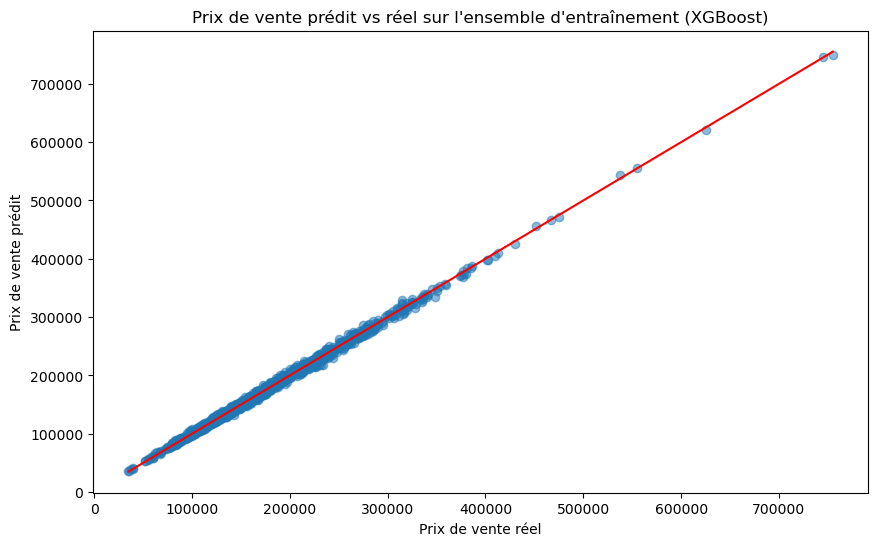

In [50]:
# Tracer les prédictions vs valeurs réelles pour l'ensemble de test
# Cette visualisation permet de comparer les prédictions du modèle avec les valeurs réelles.
# Un bon modèle aura ses prédictions proches de la ligne rouge (y = x), ce qui signifie que les prédictions sont similaires aux valeurs réelles.
# Tracer les prédictions vs valeurs réelles pour l'ensemble d'entraînement
# Tracer les prédictions vs valeurs réelles pour l'ensemble d'entraînement
# Charger les valeurs réelles de l'ensemble de test

plt.figure(figsize=(10, 6))
plt.scatter(y_train_true, y_train_pred_xgb, alpha=0.5)
plt.plot([min(y_train_true), max(y_train_true)], [min(y_train_true), max(y_train_true)], color='red')
plt.xlabel("Prix de vente réel")
plt.ylabel("Prix de vente prédit")
plt.title("Prix de vente prédit vs réel sur l'ensemble d'entraînement (XGBoost)")
plt.show()


### Analyse du graphique prédictions vs valeurs réelles :


L'objectif de ce graphique est de démontrer la performance de notre modèle indépendamment de la soumission sur kaggle. 
 - Le graphique montre la relation entre les valeurs réelles et les prédictions faites par le modèle XGBoost.
 - Les points de données représentent les paires (valeur réelle, prédiction).
 - La ligne rouge (y = x) représente les points où les prédictions sont exactement égales aux valeurs réelles.
 - Un bon ajustement est indiqué par les points proches de cette ligne rouge, ce qui suggère que les prédictions sont précises.
 - Les écarts significatifs par rapport à la ligne rouge peuvent indiquer des erreurs de prédiction ou des zones où le modèle pourrait être amélioré.
 - La proximité des points à la ligne rouge dans ce graphique indique que le modèle XGBoost est bien calibré et a une bonne capacité prédictive.
 - La légère dispersion des points autour de la ligne rouge est normale et indique des erreurs de prédiction relativement faibles et uniformément réparties.
 - Les valeurs extrêmes sont également bien prédites, montrant que le modèle généralise bien sur l'ensemble des données, y compris les valeurs extrêmes.
 - En conclusion, le modèle XGBoost démontre une haute précision et un faible biais dans les prédictions, confirmant son efficacité pour prédire les prix de vente dans ce contexte.

### ADABOOST

In [53]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
def objective_adaboost(trial):
    ab_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'estimator__max_depth': trial.suggest_int('estimator__max_depth', 1, 10)
    }

    estimator = DecisionTreeRegressor(max_depth=ab_params.pop('estimator__max_depth'))
    model = AdaBoostRegressor(estimator=estimator, **ab_params, random_state=42)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmsle_scores = []
    
    for train_index, valid_index in kf.split(X_preprocessed):
        X_train_fold, X_valid_fold = X_preprocessed.iloc[train_index], X_preprocessed.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_valid_fold)
        score = rmsle(y_valid_fold, preds)
        rmsle_scores.append(score)
    
    return np.mean(rmsle_scores)

# Utiliser Optuna pour l'optimisation bayésienne
sampler = optuna.samplers.TPESampler()
study_ab = optuna.create_study(direction='minimize', sampler=sampler)
study_ab.optimize(objective_adaboost, n_trials=50)

# Afficher les meilleurs hyperparamètres trouvés par Optuna
print("Best hyperparameters for AdaBoost =", study_ab.best_trial.params)

# Entraîner le modèle final avec les meilleurs hyperparamètres pour AdaBoost
best_params = study_ab.best_trial.params
estimator = DecisionTreeRegressor(max_depth=best_params.pop('estimator__max_depth'))
final_model_ab = AdaBoostRegressor(estimator=estimator, **best_params, random_state=42)
final_model_ab.fit(X_preprocessed, y)  # Utiliser toutes les données d'entraînement

# Évaluation finale du modèle AdaBoost
kf = KFold(n_splits=5, shuffle=True, random_state=42)
final_rmsle_scores_ab = []

for train_index, valid_index in kf.split(X_preprocessed):
    X_train_fold, X_valid_fold = X_preprocessed.iloc[train_index], X_preprocessed.iloc[valid_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]
    
    final_model_ab.fit(X_train_fold, y_train_fold)
    

[I 2024-06-09 16:55:41,465] A new study created in memory with name: no-name-4e37ae98-0148-4587-99f1-1021e7e79c4e
[I 2024-06-09 16:56:54,874] Trial 0 finished with value: 0.01201811594144855 and parameters: {'n_estimators': 646, 'learning_rate': 0.0266300771744241, 'estimator__max_depth': 4}. Best is trial 0 with value: 0.01201811594144855.
[I 2024-06-09 16:58:24,446] Trial 1 finished with value: 0.011674010989456557 and parameters: {'n_estimators': 951, 'learning_rate': 0.08656110655917369, 'estimator__max_depth': 4}. Best is trial 1 with value: 0.011674010989456557.
[I 2024-06-09 16:58:49,773] Trial 2 finished with value: 0.018883881789658035 and parameters: {'n_estimators': 593, 'learning_rate': 0.02028706426910223, 'estimator__max_depth': 1}. Best is trial 1 with value: 0.011674010989456557.
[I 2024-06-09 17:00:13,346] Trial 3 finished with value: 0.010854071986017823 and parameters: {'n_estimators': 318, 'learning_rate': 0.6231892404652669, 'estimator__max_depth': 10}. Best is tri

Best hyperparameters for AdaBoost = {'n_estimators': 480, 'learning_rate': 0.9665351113909071, 'estimator__max_depth': 7}


In [54]:
preds = final_model_ab.predict(X_valid_fold)
score = rmsle(y_valid_fold, preds)
final_rmsle_scores_ab.append(score)

print(f"Final RMSLE scores (AdaBoost): {final_rmsle_scores_ab}")
print(f"Mean Final RMSLE (AdaBoost): {np.mean(final_rmsle_scores_ab)}")

# Prédictions sur les données de test pour AdaBoost
y_test_pred_ab = final_model_ab.predict(X_test_df)
y_test_pred_ab = np.expm1(y_test_pred_ab)

Final RMSLE scores (AdaBoost): [0.009197156144999552]
Mean Final RMSLE (AdaBoost): 0.009197156144999552


### Analyse du graphique Prédictions vs Valeurs Réelles :


In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train_exp, ab_train_predictions, alpha=0.5)
plt.plot([min(y_train_exp), max(y_train_exp)], [min(y_train_exp), max(y_train_exp)], color='red')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('AdaBoost Regression: Predicted vs Actual SalePrice')
plt.show()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Conversion des logarithmes en valeurs réelles pour la comparaison
y_valid_real = np.expm1(y_valid_fold)
preds_real = np.expm1(preds)

# Création d'un DataFrame pour les valeurs réelles et prédites
comparison_df = pd.DataFrame({
    'Real': y_valid_real,
    'Predicted': preds_real
})

# Affichage des premières lignes pour vérifier
print(comparison_df.head())

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.scatter(y_valid_real, preds_real, alpha=0.3)
plt.plot([y_valid_real.min(), y_valid_real.max()], [y_valid_real.min(), y_valid_real.max()], 'k--', lw=2)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')
plt.title('Comparaison des valeurs réelles et prédites')
plt.show()

NameError: name 'y_valid_fold' is not defined

In [55]:
# Préparer les fichiers de soumission
submission_xgb = pd.DataFrame({
    'Id': test_data.index,
    'SalePrice': y_test_pred_xgb
})
submission_lasso = pd.DataFrame({
    'Id': test_data.index,
    'SalePrice': lasso_predictions
})

submission_ab = pd.DataFrame({
    'Id': test_data.index,
    'SalePrice': y_test_pred_ab
})

# Sauvegarder les fichiers de soumission
submission_xgb.to_csv('submission_xgb.csv', index=False)
submission_lasso.to_csv('lasso_submission.csv', index=False)
submission_ab.to_csv('submission_AB.csv', index=False)

print("Les fichiers de soumission sont prêts : 'submission_xgb.csv' , 'submission_AB.csv' et 'lasso_submission.csv'")


Les fichiers de soumission sont prêts : 'submission_xgb.csv' , 'submission_AB.csv' et 'lasso_submission.csv'


# Utilisation de MLFlow pour les évaluations
Chaque modèle est sauvegardé dans MLFlow afin de conserver une trace et en vue d'un futur déploiement.

In [29]:
# pip install mlflow
# pip install setuptools

Après avoir installé mlflow, nous avons d'abord dû démarrer un serveur de suivi local. La commande suivante a été utilisée dans le terminal :
- **mlflow server --host 127.0.0.1 --port 8080**

### Configuration de l'URI de suivi MLflow
MLflow a été configuré pour suivre les expériences de machine learning et gérer les modèles. L'URI de suivi est lui défini pour indiquer où les informations de suivi seront stockées. À ce moment, le nom de l'expérience est également défini pour organiser les différentes exécutions.

In [57]:
import mlflow
import warnings
from mlflow.models import infer_signature
warnings.filterwarnings('ignore', module='mlflow')

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("House Prices Prediction")

c:\Users\blerdon\anaconda3\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\blerdon\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'xgboost_regressor_model' already exists. Creat

Le modèle XGBoost a été enregistré avec MLflow.


c:\Users\blerdon\anaconda3\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'lasso_regressor_model'.
2024/06/09 18:47:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lasso_regressor_model, version 1
Created ve

Le modèle Lasso a été enregistré avec MLflow.


c:\Users\blerdon\anaconda3\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'adaboost_regressor_model' already exists. Creating a new version of this model...
2024/06/09 18:50:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name

Le modèle AdaBoost a été enregistré avec MLflow.


Created version '2' of model 'adaboost_regressor_model'.


In [ ]:
# Entraîner et enregistrer le modèle XGBoost avec MLflow
with mlflow.start_run(run_name="XGBoost Model"):
    best_params_xgb = study_xgb.best_trial.params
    final_model_xgb = xgb.XGBRegressor(**best_params_xgb, random_state=42, objective='reg:squarederror')
    
    model_pipeline_xgb = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', final_model_xgb)
    ])
    
    # Entraîner le pipeline avec les données d'entraînement
    model_pipeline_xgb.fit(X_train, y_train)
    
    # Enregistrer les hyperparamètres utilisés
    mlflow.log_params(best_params_xgb)

    # Calculer et enregistrer la métrique de perte (RMSLE)
    mean_rmsle_xgb = np.mean([rmsle_score for rmsle_score in study_xgb.trials_dataframe()['value']])
    mlflow.log_metric("mean_rmsle", mean_rmsle_xgb)

    # Définir un tag pour décrire l'exécution
    mlflow.set_tag("Training Info", "XGBoost Regressor")

    # Inférer la signature du modèle (entrée et sortie)
    signature_xgb = infer_signature(X_train, model_pipeline_xgb.predict(X_train))

    # Enregistrer le modèle avec MLflow
    model_info_xgb = mlflow.sklearn.log_model(
        sk_model=model_pipeline_xgb,
        signature=signature_xgb,
        input_example=X_train.head(),
        registered_model_name="xgboost_regressor_model",
        artifact_path="xgboost_regressor_model"
    )

print("Le modèle XGBoost a été enregistré avec MLflow.")


# Entraîner et enregistrer le modèle Lasso avec MLflow
with mlflow.start_run(run_name="Lasso Model"):
    lasso_params = {'alpha': best_alpha}  # Remplacer 'best_alpha' par la meilleure valeur alpha trouvée
    final_model_lasso = Lasso(alpha=lasso_params['alpha'], max_iter=20000)
    
    model_pipeline_lasso = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', final_model_lasso)
    ])
    
    # Entraîner le pipeline avec les données d'entraînement
    model_pipeline_lasso.fit(X_train, y_train)
    
    # Enregistrer les hyperparamètres utilisés
    mlflow.log_params(lasso_params)

    # Définir un tag pour décrire l'exécution
    mlflow.set_tag("Training Info", "Lasso Regressor")

    # Inférer la signature du modèle (entrée et sortie)
    signature_lasso = infer_signature(X_train, model_pipeline_lasso.predict(X_train))

    # Enregistrer le modèle avec MLflow
    model_info_lasso = mlflow.sklearn.log_model(
        sk_model=model_pipeline_lasso,
        signature=signature_lasso,
        input_example=X_train.head(),
        registered_model_name="lasso_regressor_model",
        artifact_path="lasso_regressor_model"
    )

print("Le modèle Lasso a été enregistré avec MLflow.")


# Entraîner et enregistrer le modèle AdaBoost avec MLflow
with mlflow.start_run(run_name="AdaBoost Model"):
    adaboost_params = {'n_estimators': 100, 'random_state': 42}  # Spécifiez les hyperparamètres d'AdaBoost
    final_model_adaboost = AdaBoostRegressor(**adaboost_params)
    
    model_pipeline_adaboost = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', final_model_adaboost)
    ])
    
    # Entraîner le pipeline avec les données d'entraînement
    model_pipeline_adaboost.fit(X_train, y_train)
    
    # Enregistrer les hyperparamètres utilisés
    mlflow.log_params(adaboost_params)

    # Définir un tag pour décrire l'exécution
    mlflow.set_tag("Training Info", "AdaBoost Regressor")

    # Inférer la signature du modèle (entrée et sortie)
    signature_adaboost = infer_signature(X_train, model_pipeline_adaboost.predict(X_train))

    # Enregistrer le modèle avec MLflow
    model_info_adaboost = mlflow.sklearn.log_model(
        sk_model=model_pipeline_adaboost,
        signature=signature_adaboost,
        input_example=X_train.head(),
        registered_model_name="adaboost_regressor_model",
        artifact_path="adaboost_regressor_model"
    )

print("Le modèle AdaBoost a été enregistré avec MLflow.")


### Éthique de l'IA dans la prédiction des prix des maisons

L'utilisation de l'intelligence artificielle pour prédire les prix des maisons présente plusieurs implications éthiques qu'il est crucial de considérer. Bien que cette technologie puisse offrir des avantages significatifs, elle peut aussi entraîner des risques et des inégalités si elle n'est pas déployée de manière responsable.

#### Bénéfices de l'IA dans la prédiction des prix des maisons

L'IA peut potentiellement bénéficier à un large éventail de parties prenantes :
- **Acheteurs de maisons** : peuvent obtenir des estimations précises des prix, facilitant la prise de décision.
- **Vendeurs de maisons** : peuvent ajuster leurs attentes de prix en fonction des analyses prédictives, augmentant les chances de vente rapide.
- **Agents immobiliers** : peuvent utiliser les prédictions pour conseiller leurs clients de manière plus informée.
- **Institutions financières** : peuvent évaluer plus précisément les risques liés aux prêts hypothécaires.

#### Création d'inégalités

Cependant, il existe des risques que l'IA puisse exacerber certaines inégalités :
- **Biais des données** : Si les données utilisées pour entraîner le modèle contiennent des biais historiques, l'IA peut perpétuer et même amplifier ces biais. Par exemple, certaines régions pourraient être sous-évaluées systématiquement.
- **Accès à la technologie** : Tous les acheteurs et vendeurs n'ont pas un accès égal à cette technologie. Ceux qui peuvent se permettre les outils basés sur l'IA pourraient avoir un avantage injuste.
- **Transparence et explicabilité** : Les décisions prises par des modèles d'IA peuvent être opaques. Les parties prenantes doivent comprendre comment et pourquoi un prix a été prédit, ce qui est crucial pour la confiance dans le système.

#### Évaluation des risques

Pour gérer ces implications éthiques, il est utile de catégoriser les risques selon leur gravité.

**Exemple de risque inacceptable :**
- **Discrimination systématique** : Le modèle prédit systématiquement des prix inférieurs pour des quartiers historiquement marginalisés.

**Risque élevé :**
- **Biais des modèles** : Le modèle pourrait apprendre des biais présents dans les données historiques, menant à des prédictions injustes pour certaines régions ou groupes démographiques.
- **Violation de la vie privée** : Utilisation de données personnelles sans consentement approprié pourrait conduire à des problèmes de confidentialité.

**Risque limité :**
- **Accès inégal aux outils d'IA** : Certaines parties de la population peuvent ne pas avoir accès aux prédictions de prix basées sur l'IA, créant une disparité d'information.
- **Dépendance excessive** : Confiance excessive dans les prédictions de l'IA sans vérification humaine peut conduire à des décisions de marché suboptimales.

**Risque minimal :**
- **Erreurs de prédiction** : Comme tout modèle prédictif, des erreurs peuvent survenir, mais avec une bonne gestion et validation continue, ces erreurs peuvent être minimisées et corrigées.
- **Impact sur les professionnels** : Les agents immobiliers et autres professionnels pourraient initialement percevoir l'IA comme une menace, mais elle peut aussi être vue comme un outil complémentaire qui améliore leurs services.

# Conclusion

Notre projet de prédiction des prix des maisons a démontré l'efficacité des modèles de Machine Learning pour fournir des estimations précises, qui aide les vendeurs à fixer des prix compétitifs. En intégrant ces modèles dans une plateforme en ligne, nous avons offert une solution pratique et accessible qui peut transformer la manière dont les propriétés seront vendues, en accélérant ainsi les transactions et en optimisant les revenus des vendeurs.

Nous recommandons de continuer à affiner les modèles avec de nouvelles données ainsi que d'effectuer des analyses régulières dans l'objectif de garantir la précision et l'équité des prédictions !
